In [ ]:
!pip install kneed
!pip install kaggle

In [ ]:
!kaggle datasets download -d mrmorj/dataset-of-songs-in-spotify

  0% 0.00/3.06M [00:00<?, ?B/s]
100% 3.06M/3.06M [00:00<00:00, 103MB/s]


In [ ]:
!kaggle datasets download -d mrmorj/dataset-of-songs-in-spotify

In [ ]:
from kneed import KneeLocator
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np
from numpy import mean
from numpy import std
from numpy import percentile
import pandas as pd
import pickle
import os
import scipy as sp
from scipy.cluster.vq import kmeans2
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
import zipfile

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/MyDrive/Datasets/Audio Features') #Lakshya

In [ ]:
# os.chdir('drive/MyDrive/Spotify Project/audio_features') #Navneeth

In [ ]:
arr = os.listdir()
df1 = pd.DataFrame()
a = (pd.read_json(f) for f in arr if f.endswith('.json'))
df1 = pd.concat(a, ignore_index=True)

In [ ]:
df_kaggle = pd.read_csv('/content/drive/MyDrive/Datasets/Audio Features/genres_v2.csv', low_memory= False)

In [ ]:
frames = [df_kaggle[df1.columns], df1]
df = pd.concat(frames)

In [ ]:
zf = zipfile.ZipFile('/content/drive/MyDrive/Datasets/Audio Features/SpotifyRecommenderSystem/data/data.csv.zip') # having First.csv zipped file.
df_new_data = pd.read_csv(zf.open('data.csv'))

In [ ]:
# df_new_data[df_new_data.id if df_new_data.id not in df.id]
# df_new_data['id'].mask(df_new_data['id'].isin(df.id).values)
numerical_cols = df1.select_dtypes(include=np.number).columns.tolist()
numerical_cols.pop(numerical_cols.index('duration_ms'))
numerical_cols.pop(numerical_cols.index('time_signature'))
numerical_cols.append('id')
# df_new_data[numerical_cols]

In [ ]:
frames = [df_kaggle[numerical_cols], df1[numerical_cols], df_new_data[numerical_cols]]
spotify_data = pd.concat(frames)

In [ ]:
df.drop_duplicates(inplace = True)
spotify_data.drop_duplicates(inplace = True)

**Definitions:**

**acousticness** : A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.

**danceability** : Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.

**energy** : Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.

**key** : The key the track is in. Integers map to pitches using standard Pitch Class notation . E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on.

**loudness** : The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db.

**mode** : Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.

**speechiness** : Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.

**instrumentalness** : Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.

**liveness** : Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.

**valence** : A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

**tempo** : The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.

In [ ]:
def scaled_numeric_features(df):
  numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
  x = df[numerical_cols]
  min_max_scaler = StandardScaler()
  x_scaled = min_max_scaler.fit_transform(x)
  df_numeric = pd.DataFrame(x_scaled, columns= numerical_cols)  
  return df_numeric

In [ ]:
df_numeric = scaled_numeric_features(df)

In [ ]:
df_numeric.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,1.495299,0.503762,-0.930927,0.093455,0.820351,3.099590,-0.503398,-0.665916,-0.884772,-0.182795,0.797906,-1.228180,0.190182
1,0.847930,-0.908223,0.737409,0.126768,0.820351,-0.181829,0.670155,-0.703386,-0.508804,-1.194291,-0.611767,-0.283922,0.190182
2,1.605120,0.851260,-0.096759,0.735101,0.820351,-0.346574,-0.661614,-0.703374,1.021581,-1.518351,2.852117,-1.471297,0.190182
3,-0.556628,0.358605,-1.487038,0.753250,0.820351,0.045539,-0.627563,-0.703386,-0.532904,-0.999625,1.805854,-1.236480,-2.717025
4,1.304556,-0.331992,-0.930927,0.017879,0.820351,1.876043,0.037289,-0.703386,-0.219597,0.588232,0.495250,-1.239912,0.190182


In [ ]:
# numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
# numerical_cols.pop(numerical_cols.index('duration_ms'))
# numerical_cols.pop(numerical_cols.index('time_signature'))

'time_signature'

In [ ]:
# x = df[numerical_cols] # returns a numpy array
# min_max_scaler = StandardScaler()
# x_scaled = min_max_scaler.fit_transform(x)
# df_numeric = pd.DataFrame(x_scaled, columns= numerical_cols)

In [ ]:
df_numeric.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,1.495299,0.503762,-0.930927,0.093455,0.820351,3.099590,-0.503398,-0.665916,-0.884772,-0.182795,0.797906,-1.228180,0.190182
1,0.847930,-0.908223,0.737409,0.126768,0.820351,-0.181829,0.670155,-0.703386,-0.508804,-1.194291,-0.611767,-0.283922,0.190182
2,1.605120,0.851260,-0.096759,0.735101,0.820351,-0.346574,-0.661614,-0.703374,1.021581,-1.518351,2.852117,-1.471297,0.190182
3,-0.556628,0.358605,-1.487038,0.753250,0.820351,0.045539,-0.627563,-0.703386,-0.532904,-0.999625,1.805854,-1.236480,-2.717025
4,1.304556,-0.331992,-0.930927,0.017879,0.820351,1.876043,0.037289,-0.703386,-0.219597,0.588232,0.495250,-1.239912,0.190182


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5be31c96d0>,
      dtype=object)

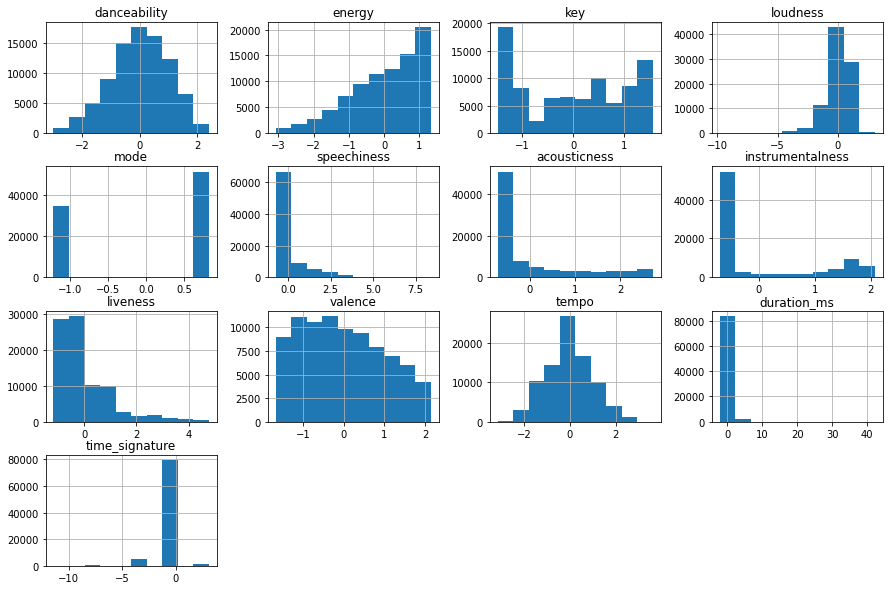

In [ ]:
df_numeric.hist( figsize=(15, 10))

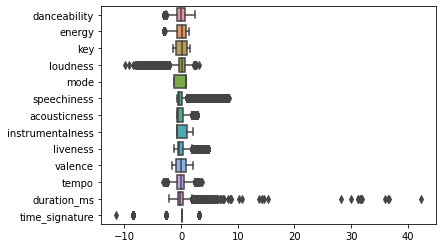

In [ ]:
sns.boxplot(data = df_numeric, orient= "h")

We need to treat some outliers for our model to train properly.

In [ ]:
def iqr_outlier_treatment(data):
  for col_name in data.columns:
    q25, q75 = percentile(data[col_name], 25), percentile(data[col_name], 75)
    iqr = q75 - q25
    # calculate the outlier cutoff
    cut_off = iqr
    lower, upper = q25 - cut_off, q75 + cut_off
    # identify outliers
    data = data[(data[col_name]>= lower) & (data[col_name]<= upper)]
  return data
# data['tempo'].describe()

In [ ]:
sns.pairplot(data = df_numeric)

In [ ]:
df_numeric.corr()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
danceability,1.000000,-0.028956,0.011192,0.073241,-0.023802,0.216945,-0.095140,-0.094488,-0.109007,0.332360,0.016311,-0.062834,0.140780
energy,-0.028956,1.000000,0.035055,0.735169,-0.040779,0.082177,-0.688963,0.075191,0.199592,0.049881,0.217859,0.064463,0.145190
key,0.011192,0.035055,1.000000,0.012482,-0.197586,-0.006448,-0.026239,0.032331,-0.004249,0.020572,-0.003607,0.034743,0.006368
loudness,0.073241,0.735169,0.012482,1.000000,-0.021511,0.130551,-0.545523,-0.224381,0.134129,0.080271,0.241202,-0.138499,0.129956
mode,-0.023802,-0.040779,-0.197586,-0.021511,1.000000,-0.014109,0.048859,-0.047077,0.004509,0.048159,-0.033671,-0.055770,-0.011967
speechiness,0.216945,0.082177,-0.006448,0.130551,-0.014109,1.000000,-0.087248,-0.208480,0.108477,0.033303,0.200179,-0.154139,0.037464
acousticness,-0.095140,-0.688963,-0.026239,-0.545523,0.048859,-0.087248,1.000000,-0.075774,-0.095327,0.093004,-0.231324,-0.095243,-0.151303
instrumentalness,-0.094488,0.075191,0.032331,-0.224381,-0.047077,-0.208480,-0.075774,1.000000,-0.021699,-0.306603,-0.036986,0.425124,-0.020995
liveness,-0.109007,0.199592,-0.004249,0.134129,0.004509,0.108477,-0.095327,-0.021699,1.000000,-0.026266,0.040798,0.006751,0.008672
valence,0.332360,0.049881,0.020572,0.080271,0.048159,0.033303,0.093004,-0.306603,-0.026266,1.000000,-0.047020,-0.238970,0.063658


Using PCA to understand the feature importance in the dataset

In [ ]:
def dim_red_pca(X, d=0, corr=False):
    r"""
    Performs principal component analysis.

    Parameters
    ----------
    X : array, (n, d)
        Original observations (n observations, d features)

    d : int
        Number of principal components (default is ``0`` => all components).

    corr : bool
        If true, the PCA is performed based on the correlation matrix.

    Notes
    -----
    Always all eigenvalues and eigenvectors are returned,
    independently of the desired number of components ``d``.

    Returns
    -------
    Xred : array, (n, m or d)
        Reduced data matrix

    e_values : array, (m)
        The eigenvalues, sorted in descending manner.

    e_vectors : array, (n, m)
        The eigenvectors, sorted corresponding to eigenvalues.

    """
    # Center to average
    X_ = X-X.mean(0)
    # Compute correlation / covarianz matrix
    if corr:
        CO = np.corrcoef(X_.T)
    else:
        CO = np.cov(X_.T)
    # Compute eigenvalues and eigenvectors
    e_values, e_vectors = sp.linalg.eigh(CO)

    # Sort the eigenvalues and the eigenvectors descending
    idx = np.argsort(e_values)[::-1]
    e_vectors = e_vectors[:, idx]
    e_values = e_values[idx]
    # Get the number of desired dimensions
    d_e_vecs = e_vectors
    if d > 0:
        d_e_vecs = e_vectors[:, :d]
    else:
        d = None
    # Map principal components to original data
    LIN = np.dot(d_e_vecs, np.dot(d_e_vecs.T, X_.T)).T
    return LIN[:, :d], e_values, e_vectors

In [ ]:
clust,labels_ = kmeans2(df_numeric,3) 

[Text(0, 0.5, 'Weight'), Text(0.5, 0, 'Features')]

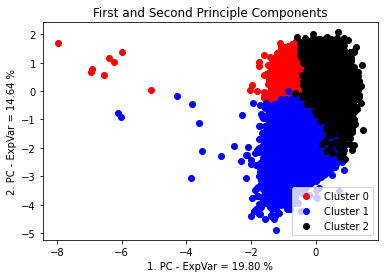

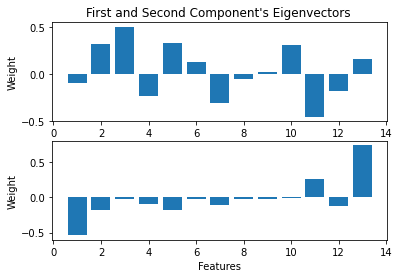

In [ ]:
Xred, evals, evecs = dim_red_pca(df_numeric,2)   

xlab = '1. PC - ExpVar = {:.2f} %'.format(evals[0]/sum(evals)*100) # determine variance portion
ylab = '2. PC - ExpVar = {:.2f} %'.format(evals[1]/sum(evals)*100)
# plot the clusters, each set separately
plt.figure()    
ax = plt.gca()
scatterHs = []
clr = ['r', 'b', 'k']
for cluster in set(labels_):
    scatterHs.append(ax.scatter(Xred[labels_ == cluster, 0], Xred[labels_ == cluster, 1], 
                   color=clr[cluster], label='Cluster {}'.format(cluster)))
plt.legend(handles=scatterHs,loc=4)
plt.setp(ax, title='First and Second Principle Components', xlabel=xlab, ylabel=ylab)
# plot also the eigenvectors for deriving the influence of each feature
fig, ax = plt.subplots(2,1)
ax[0].bar([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],evecs[0])
plt.setp(ax[0], title="First and Second Component's Eigenvectors ", ylabel='Weight')
ax[1].bar([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],evecs[1])
plt.setp(ax[1], xlabel='Features', ylabel='Weight')

In [ ]:
# X_df = df_numeric[['danceability', 'energy', 'acousticness', 'instrumentalness', 'valence']]
X_df_outlier = df_numeric[['danceability', 'energy', 'acousticness', 'instrumentalness', 'valence','tempo']]

In [ ]:
X_df = iqr_outlier_treatment(X_df_outlier)

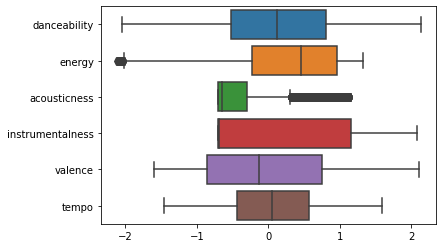

In [ ]:
sns.boxplot(data = X_df, orient= "h")

In [ ]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

In [ ]:
# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X_df)
    sse.append(kmeans.inertia_)

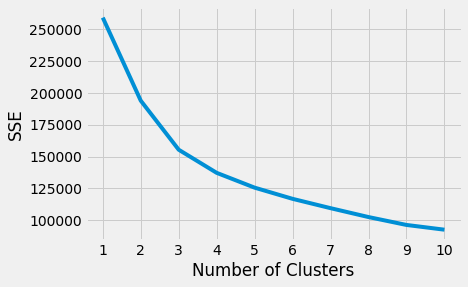

In [ ]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [ ]:
kl = KneeLocator(
    range(1, 11), sse, curve="convex", direction="decreasing"
)

kl.elbow

3

In [ ]:
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    # kmeans.fit(df_numeric) NM: We were kinda fitting all the features, didnt remove the other ones.
    kmeans.fit(X_df)
    score = silhouette_score(X_df, kmeans.labels_)
    silhouette_coefficients.append(score)

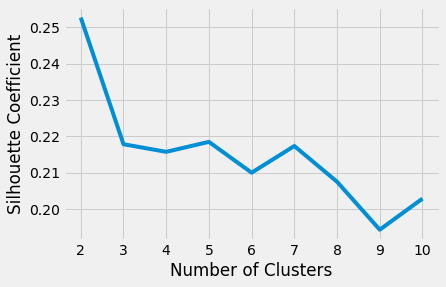

In [ ]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

Trying out the cluster prediction strength to validate the optimal number of clusters.

In [ ]:
kmeans = KMeans(
    init = "k-means++",
    n_init = 25,
    n_clusters=3,
    max_iter=500,
    random_state=420
  )

In [ ]:
# X = np.array(X_df)

X = np.array(X_df_outlier)

In [ ]:
y_kmeans = kmeans.fit_predict(X)

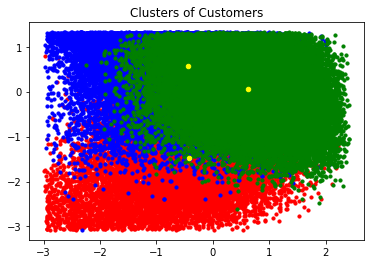

In [ ]:
plt.clf()
plt.scatter(X[y_kmeans==0, 0], X[y_kmeans==0, 1], s=10, c='red', label ='Cluster 1')
plt.scatter(X[y_kmeans==1, 0], X[y_kmeans==1, 1], s=10, c='blue', label ='Cluster 2')
plt.scatter(X[y_kmeans==2, 0], X[y_kmeans==2, 1], s=10, c='green', label ='Cluster 3')
plt.scatter(X[y_kmeans==3, 0], X[y_kmeans==3, 1], s=10, c='cyan', label ='Cluster 4')
# plt.scatter(X[y_kmeans==4, 0], X[y_kmeans==4, 1], s=10, c='black', label ='Cluster 5')
# plt.scatter(X[y_kmeans==5, 0], X[y_kmeans==5, 1], s=10, c='gray', label ='Cluster 6')
# plt.scatter(X[y_kmeans==6, 0], X[y_kmeans==6, 1], s=10, c='purple', label ='Cluster 7')
# plt.scatter(X[y_kmeans==7, 0], X[y_kmeans==7, 1], s=10, c='orange', label ='Cluster 8')
# plt.scatter(X[y_kmeans==8, 0], X[y_kmeans==8, 1], s=10, c='cyan', label ='Cluster 9')
#Plot the centroid. This time we're going to use the cluster centres  #attribute that returns here the coordinates of the centroid.
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=20, c='yellow', label = 'Centroids')
plt.title('Clusters of Customers')
plt.show()

In [ ]:
kmeans.inertia_

329703.01675535797

In [ ]:
kmeans.n_iter_

9

In [ ]:
kmeans.cluster_centers_

array([[-4.26891835e-01, -1.47162111e+00,  1.75973070e+00,
         1.17024525e-03, -1.88889209e-01, -5.70299876e-01],
       [-4.46374472e-01,  5.79105574e-01, -5.79224118e-01,
         4.88806622e-01, -6.66645544e-01,  2.55343310e-01],
       [ 6.12830478e-01,  6.79422007e-02, -1.90584919e-01,
        -4.72404937e-01,  7.24078072e-01, -3.52266624e-03]])

In [ ]:
kmeans.labels_

array([2, 0, 1, ..., 1, 1, 2], dtype=int32)

###### Understanding the clusters

In [ ]:
clusters = pd.Series(kmeans.labels_)

In [ ]:
X_df['clusters'] = clusters

In [ ]:
X_df['clusters'].value_counts()

1    30801
2    29178
0     2226
Name: clusters, dtype: int64

In [ ]:
# features = ['danceability', 'energy', 'acousticness', 'instrumentalness', 'valence']
features = ['danceability', 'energy', 'acousticness', 'instrumentalness', 'valence','tempo']
df_cluster_avg = X_df.groupby('clusters').agg('mean')

In [ ]:
df_cluster_avg

,danceability,energy,acousticness,instrumentalness,valence,tempo
clusters,,,,,,
0,-0.258577,-1.179072,0.652722,-0.181460,-0.476658,-0.367181
1,-0.320288,0.597157,-0.590766,0.516238,-0.663939,0.226024
2,0.599789,0.105560,-0.296441,-0.439868,0.698151,-0.079311


In [ ]:
cluster_1_features = df_cluster_avg.iloc[0].tolist()
cluster_1_features = np.array(cluster_1_features + [cluster_1_features[0]])
cluster_2_features = df_cluster_avg.iloc[1].tolist()
cluster_2_features = np.array(cluster_2_features + [cluster_2_features[0]])
cluster_3_features = df_cluster_avg.iloc[2].tolist()
cluster_3_features = np.array(cluster_3_features + [cluster_3_features[0]])

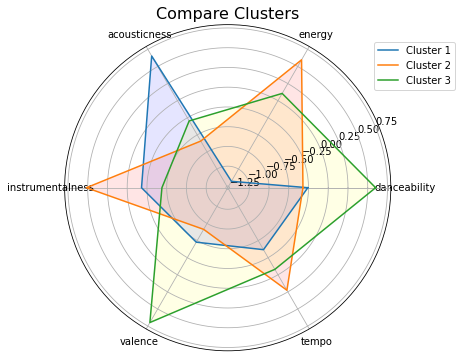

In [ ]:
angles = np.linspace(start=0, stop=2*np.pi, num=len(cluster_1_features))

# create matplotlib figure and polar plot with labels, title, and legend
plt.figure(figsize=(6,6))
plt.subplot(polar=True)
plt.plot(angles, cluster_1_features)
plt.fill(angles, cluster_1_features, 'blue', alpha=0.1)
plt.plot(angles, cluster_2_features)
plt.fill(angles, cluster_2_features, 'red', alpha=0.1)
plt.plot(angles, cluster_3_features)
plt.fill(angles, cluster_3_features, 'yellow', alpha=0.1)

# use thetagrids to place labels at the specified angles using degrees
lines, labels = plt.thetagrids(np.degrees(angles), labels=features)
plt.title('Compare Clusters', y=1.0, fontdict={'fontsize': 16})
plt.legend(labels=['Cluster 1','Cluster 2', 'Cluster 3'],loc=(0.95, 0.8));

In [ ]:
import plotly.graph_objects as go
import plotly.offline as pyo


categories = ['danceability', 'energy', 'acousticness', 'instrumentalness', 'valence','tempo']
categories = [*categories, categories[0]]


fig = go.Figure(
    data=[
        go.Scatterpolar(r=cluster_1_features, theta=categories, fill='toself', name='Cluster 1'),
        go.Scatterpolar(r=cluster_2_features, theta=categories, fill='toself', name='Cluster 2'),
        go.Scatterpolar(r=cluster_3_features, theta=categories, fill='toself', name='Cluster 3')
    ],
    layout=go.Layout(
        title=go.layout.Title(text='Cluster comparison'),
        polar={'radialaxis': {'visible': True}},
        showlegend=True
    )
)

# pyo.plot(fig, show_link = True)
pyo.iplot(fig)

From the looks of it we can mostly see that:
  

*   Cluster 1 is more instrumental, fast paced and energetic songs.
*   Cluster 2 is highly acoustic
*   Cluster 3 is more happy dance and full of energy

So following this pattern we can rename our clusters to:


*   Cluster 1 - Classically Acoustics
*   Cluster 2 - Definitely Pump
*   Cluster 3 - Happy Trance 





In [ ]:
final_df = X_df
final_df = final_df.astype({'clusters': str})
final_df['clusters'].replace({'0': 'Classically Acoustics', '1': 'Definitely Pump', '2': 'Happy Trance'}, inplace = True)

Now we have created a Dataset with Labels, which we can use to create a random forest model to calculate thresholds for different variable values for our recommendation model.

In [ ]:
X_rf = final_df.iloc[:,:-1]
Y_rf = final_df['clusters']

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X_rf, Y_rf, random_state = 42, test_size = 0.25)

In [ ]:
print(x_train.shape, y_train.shape)

(46653, 6) (46653,)


In [ ]:
# define the model
rf_model = RandomForestClassifier()
# evaluate the model
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# n_scores = cross_val_score(rf_model, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
# print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

In [ ]:
# fit the model on the whole dataset
rf_model.fit(x_train, y_train)

In [ ]:
y_pred = rf_model.predict(x_test)

In [ ]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred)*100)

In [ ]:
confusion_matrix(y_test,y_pred )
dt_report = (classification_report(y_test,y_pred))
print(dt_report)

In [ ]:
feature = x_train.columns
class_name = y_train.unique()

Saving the model in pickl form to predict clusters for new data.

In [ ]:
# # save the model to disk
# filename = 'rf_predictor.sav'
# pickle.dump(rf_model, open(filename, 'wb'))

# save the model to disk
filename2 = 'kmeans_cluster.sav'
pickle.dump(kmeans, open(filename2, 'wb'))

In [ ]:
filename = 'rf_predictor.sav'
loaded_model = pickle.load(open(filename, 'rb'))

filename2 = 'kmeans_cluster.sav'
loaded_model_kmeans = pickle.load(open(filename2, 'rb'))

In [ ]:
!pip install spotipy --upgrade

In [ ]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

In [ ]:
cid = 'Your_cllient_id'
secret = 'Your_client_secret'

client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)

sap = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

In [ ]:
def call_playlist(creator, playlist_id):
    
    #step1

    playlist_features_list = ["artist","album","track_name",  "track_id","danceability","energy","key"
    ,"loudness","mode",'acousticness', "speechiness","instrumentalness","liveness"
    ,"valence","tempo", "duration_ms","time_signature"]
    
    playlist_df = pd.DataFrame(columns = playlist_features_list)
    
    #step2
    try:
      tracks = sap.user_playlist_tracks(creator, playlist_id)
      playlist = tracks["items"]
      try:
        while tracks['next']:
          tracks = sap.next(tracks)
          playlist.extend(tracks['items'])
      except KeyError:
        playlist = tracks["items"]
    except KeyError:
      playlist = sap.user_playlist_tracks(creator, playlist_id)
      playlist = tracks["tracks"]["items"]
      try:
        while tracks['next']:
          tracks = sap.next(tracks)
          playlist.extend(tracks['items'])
      except KeyError:
        playlist = tracks["tracks"]["items"]
    for track in playlist:
        # Create empty dict
        playlist_features = {}
        # Get metadata
        playlist_features["artist"] = track["track"]["album"]["artists"][0]["name"]
        playlist_features["album"] = track["track"]["album"]["name"]
        playlist_features["track_name"] = track["track"]["name"]
        playlist_features["track_id"] = track["track"]["id"]
        
        # Get audio features
        audio_features = sap.audio_features(playlist_features["track_id"])[0]
        for feature in playlist_features_list[4:]:
            playlist_features[feature] = audio_features[feature]
        
        # Concat the dfs
        track_df = pd.DataFrame(playlist_features, index = [0])
        playlist_df = pd.concat([playlist_df, track_df], ignore_index = True)

    #Step 3
        
    return playlist_df

In [ ]:
Spotify_playlist_url = 'https://open.spotify.com/playlist/71EUGDSRiAwNhodP0GIJif'

In [ ]:
user_df = call_playlist("spotify","71EUGDSRiAwNhodP0GIJif")

In [ ]:
user_df = call_playlist("spotify","71G2FpzI3GXSlsG9Bj6Mtv?si=Nt5bxeG0RyuMvlcmgNMzbw&dl_branch=1&nd=1")

In [ ]:
user_df = call_playlist("spotify","7zmVBSPcVYuY0KOjhp2A4S?si=Ynl13h_9SK-AikB74PottA&utm_source=copy-link&dl_branch=1&nd=1")

In [ ]:
# playlist_features_list = ["artist","album","track_name",  "track_id","danceability","energy","key"
#     ,"loudness","mode",'acousticness', "speechiness","instrumentalness","liveness"
#     ,"valence","tempo", "duration_ms","time_signature"]
# playlist_df = pd.DataFrame(columns = playlist_features_list)
    
# #step2
# playlist_id = '37i9dQZF1DXcBWIGoYBM5M?si=84cbfb4878914c50'
# creator = 'spotify'

# playlist = sp.user_playlist_tracks(creator, playlist_id)["items"]

In [ ]:
user_df.head()

,artist,album,track_name,track_id,danceability,energy,key,loudness,mode,acousticness,speechiness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,John Legend,Love In The Future (Expanded Edition),All of Me,3U4isOIWM3VvDubwSI3y7a,0.422,0.2640,8,-7.064,1,0.922,0.0322,0,0.1320,0.331,119.930,269560,4
1,Sam Smith,In The Lonely Hour,Stay With Me,5Nm9ERjJZ5oyfXZTECKmRt,0.418,0.4200,0,-6.444,1,0.588,0.0414,6.39e-05,0.1100,0.184,84.094,172724,4
2,Passenger,All The Little Lights,Let Her Go,2jyjhRf6DVbMPU5zxagN2h,0.509,0.5380,7,-7.335,1,0.385,0.0572,0,0.1040,0.244,75.089,252867,4
3,Howard Shore,The Hobbit - The Desolation Of Smaug (Original...,"I See Fire - From ""The Hobbit - The Desolation...",3B7udSGy2PfgoCniMSb523,0.581,0.0549,10,-20.514,0,0.559,0.0397,0,0.0718,0.234,152.037,300840,4
4,Plain White T's,All That We Needed,Hey There Delilah,4RCWB3V8V0dignt99LZ8vH,0.656,0.2910,2,-10.572,1,0.872,0.0293,0,0.1140,0.298,103.971,232533,4


In [ ]:
user_df['instrumentalness'] = user_df['instrumentalness'].astype(np.float64)

In [ ]:
numerical_cols = user_df.select_dtypes(include=np.number).columns.tolist()

In [ ]:
numerical_cols

['danceability',
 'energy',
 'loudness',
 'acousticness',
 'speechiness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo']

In [ ]:
X_user_df = scaled_numeric_features(user_df[['danceability', 'energy', 'acousticness', 'instrumentalness', 'valence','tempo']])

In [ ]:
y_label = loaded_model.predict(X_user_df)
y_label_kmeans = loaded_model_kmeans.fit_predict(X_user_df)

In [ ]:
X_user_df['Labels_rf'] = y_label
X_user_df['Labels_kmeans'] = y_label_kmeans
X_user_df = X_user_df.astype({'Labels_kmeans': str})
X_user_df['Labels_kmeans'].replace({'0': 'Classically Acoustics', '1': 'Definitely Pump', '2': 'Happy Trance'}, inplace = True)

In [ ]:
X_user_df

,danceability,energy,acousticness,instrumentalness,valence,tempo,Labels_rf,Labels_kmeans
0,-1.177425,-1.054567,1.346787,-0.388801,-0.224539,0.221395,Classically Acoustics,Definitely Pump
1,-1.210275,-0.382874,0.405654,-0.388513,-1.206031,-0.967547,Definitely Pump,Definitely Pump
2,-0.462940,0.125201,-0.166353,-0.388801,-0.805422,-1.266309,Definitely Pump,Classically Acoustics
3,0.128358,-1.954893,0.323939,-0.388801,-0.872190,1.286618,Classically Acoustics,Definitely Pump
4,0.744293,-0.938312,1.205899,-0.388801,-0.444874,-0.308082,Classically Acoustics,Definitely Pump
5,-0.783226,-1.239713,0.701519,-0.388801,-0.671886,0.678710,Classically Acoustics,Definitely Pump
6,1.532690,-0.016888,0.256312,-0.388789,0.363021,-0.706243,Happy Trance,Classically Acoustics
7,-0.462940,-0.128837,-0.448129,-0.309994,-0.438197,1.085232,Definitely Pump,Classically Acoustics
8,-0.799651,-0.305371,1.248166,1.268393,1.437989,-1.231473,Happy Trance,Happy Trance
9,1.614815,-0.507740,1.191810,-0.386455,-0.064295,0.819449,Happy Trance,Definitely Pump


In [ ]:
features = ['danceability', 'energy', 'acousticness', 'instrumentalness', 'valence','tempo']
df_cluster_avg = X_user_df.groupby('Labels_kmeans').agg('mean')

In [ ]:
df_cluster_avg

,danceability,energy,acousticness,instrumentalness,valence,tempo
Labels_kmeans,,,,,,
Classically Acoustics,0.276769,0.762755,-0.824099,-0.261558,-0.093387,-0.032822
Definitely Pump,-0.540137,-1.074416,0.977378,-0.113678,-0.473584,0.183974
Happy Trance,0.508869,0.021863,0.587869,1.599528,2.014420,-0.460078


In [ ]:
cluster_1_features = df_cluster_avg.iloc[0].tolist()
cluster_1_features = np.array(cluster_1_features + [cluster_1_features[0]])
cluster_2_features = df_cluster_avg.iloc[1].tolist()
cluster_2_features = np.array(cluster_2_features + [cluster_2_features[0]])
cluster_3_features = df_cluster_avg.iloc[2].tolist()
cluster_3_features = np.array(cluster_3_features + [cluster_3_features[0]])

In [ ]:
import plotly.graph_objects as go
import plotly.offline as pyo


categories = ['danceability', 'energy', 'acousticness', 'instrumentalness', 'valence','tempo']
categories = [*categories, categories[0]]


fig = go.Figure(
    data=[
        go.Scatterpolar(r=cluster_1_features, theta=categories, fill='toself', name='Cluster 1'),
        go.Scatterpolar(r=cluster_2_features, theta=categories, fill='toself', name='Cluster 2'),
        go.Scatterpolar(r=cluster_3_features, theta=categories, fill='toself', name='Cluster 3')
    ],
    layout=go.Layout(
        title=go.layout.Title(text='Cluster comparison'),
        polar={'radialaxis': {'visible': True}},
        showlegend=True
    )
)

# pyo.plot(fig, show_link = True)
pyo.iplot(fig)

In [ ]:
X_user_df.Labels_rf.value_counts()

Happy Trance             36
Definitely Pump          34
Classically Acoustics     9
Name: Labels_rf, dtype: int64

In [ ]:
X_user_df.Labels_kmeans.value_counts()

Classically Acoustics    14
Definitely Pump          11
Happy Trance              4
Name: Labels_kmeans, dtype: int64

In [ ]:
user_df[X_user_df['Labels_rf']== 'Definitely Pump']

,artist,album,track_name,track_id,danceability,energy,key,loudness,mode,acousticness,speechiness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
2,MGMT,Oracular Spectacular,Kids,1jJci4qxiYcOHhQR247rEU,0.451,0.931,9,-3.871,1,0.000760,0.0719,0.004900,0.3610,0.1720,122.961,302840,4
3,MGMT,Oracular Spectacular,Time to Pretend,4iG2gAwKXsOcijVaVXzRPW,0.438,0.940,2,-3.249,1,0.000087,0.0452,0.077700,0.3000,0.4210,100.990,261000,3
7,Tame Impala,Currents,Eventually,5M4yti0QxgqJieUYaEXcpw,0.424,0.615,9,-6.217,0,0.015800,0.0325,0.000389,0.0844,0.1550,77.935,318591,4
8,Tame Impala,Lonerism,Mind Mischief,6ewQE1dNPv9qqlnB1CxrvM,0.250,0.942,6,-3.235,1,0.081500,0.0545,0.000970,0.3670,0.8220,161.333,271880,4
11,Tame Impala,Currents,Yes I'm Changing,0xtIp0lgccN85GfGOekS5L,0.373,0.609,0,-7.000,1,0.108000,0.0316,0.000427,0.0755,0.3540,179.955,270680,4
14,Arctic Monkeys,"Whatever People Say I Am, That's What I'm Not",A Certain Romance,0eDQj41kzBhMKQIkTt6OJR,0.455,0.881,11,-5.587,1,0.000566,0.0401,0.000061,0.1100,0.2010,137.949,331200,4
15,Tame Impala,Lonerism,Feels Like We Only Go Backwards,0LtOwyZoSNZKJWHqjzADpW,0.303,0.900,2,-2.352,0,0.027700,0.0574,0.635000,0.1100,0.4910,149.508,192960,4
21,Kings of Leon,Only By The Night,Closer,47jpI85aNpUG0KDLpTPVEq,0.398,0.768,11,-4.624,0,0.469000,0.0392,0.000020,0.1060,0.2350,108.685,237480,5
27,Massive Attack,Mezzanine,Angel,7uv632EkfwYhXoqf8rhYrg,0.714,0.309,7,-10.796,1,0.015700,0.0291,0.807000,0.0777,0.0671,107.346,379533,4
29,Muse,The Resistance,Resistance,1C2QJNTmsTxCDBuIgai8QV,0.467,0.774,9,-6.569,0,0.061600,0.0485,0.289000,0.1080,0.0916,135.006,346693,4


In [ ]:
song_list = user_df.track_id

In [ ]:
def percentage_class_in_df(d):
  s = sum(d.values())
  b={}
  for k, v in d.items():
      pct = v / s
      b[k] = pct
  return b

In [ ]:
a = percentage_class_in_df(dict(X_user_df.Labels_kmeans.value_counts()))

In [ ]:
a

{'Classically Acoustics': 0.2222222222222222,
 'Definitely Pump': 0.37037037037037035,
 'Happy Trance': 0.4074074074074074}

In [ ]:
df_cluster_avg

,danceability,energy,acousticness,valence,tempo
Labels_kmeans,,,,,
Classically Acoustics,-0.508108,0.001770,-0.156772,-0.985696,-1.093676
Definitely Pump,-0.317579,-1.020164,0.954273,-0.141079,0.467441
Happy Trance,0.565858,0.926456,-0.782009,0.665906,0.171605


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
def base_data_creation (user_df, spotify_data):
  number_cols = ['danceability', 'energy', 'acousticness', 'instrumentalness', 'valence','tempo']
  temp_df = spotify_data[number_cols]
  temp_df = scaled_numeric_features(temp_df)
  temp_df['id'] = spotify_data['id'].values
  exlcude_id = user_df[user_df['track_id'].isin(temp_df.id.values)].track_id
  temp_df = temp_df[~temp_df['id'].isin(exlcude_id.values)]
  return temp_df


In [ ]:
def calculate_cosine_similarity(user_vector, recommendor_frame, n_songs):
  redefined_frame = recommendor_frame.iloc[:,:-1]
  # temp_df = recommendor_frame.iloc[:,:-1]
  # redefined_frame = temp_df[(temp_df['danceability']>=(user_vector_temp[0]-user_vector_temp[0]*.2)) & 
  #           (temp_df['danceability']>=(user_vector_temp[0]+user_vector_temp[0]*.2))
  #           & (temp_df['energy']>=(user_vector_temp[1]-user_vector_temp[1]*.2))
  #           & (temp_df['energy']>=(user_vector_temp[1]+user_vector_temp[1]*.2))
  #           & (temp_df['acousticness']>=(user_vector_temp[2]-user_vector_temp[2]*.2))
  #           & (temp_df['acousticness']>=(user_vector_temp[2]+user_vector_temp[2]*.2))
  #           & (temp_df['instrumentalness']>=(user_vector_temp[3]-user_vector_temp[3]*.2))
  #           & (temp_df['instrumentalness']>=(user_vector_temp[3]+user_vector_temp[3]*.2))
  #           & (temp_df['valence']>=(user_vector_temp[4]-user_vector_temp[4]*.2))
  #           & (temp_df['valence']>=(user_vector_temp[4]+user_vector_temp[4]*.2))
  #           & (temp_df['tempo']>=(user_vector_temp[5]-user_vector_temp[5]*.2))
  #           & (temp_df['tempo']>=(user_vector_temp[5]+user_vector_temp[5]*.2))]
  cosine_values = redefined_frame.apply(lambda x: cosine_similarity(np.array(user_vector).reshape(1,-1), np.array(x).reshape(1,-1)), axis =1)
  index = list(np.argsort(cosine_values)[:n_songs])
  rec_songs = recommendor_frame.iloc[index]
  return rec_songs

In [ ]:
def recommended_song_dataframe(ids, key):
  tracks = sap.tracks(ids)
  recommended_list = {}
  recommended_df = pd.DataFrame()
  playlist = tracks["tracks"]
  for track in playlist:
    recommended_list['Song name'] = track['name']
    recommended_list['artist'] = track['album']['artists'][0]['name']
    recommended_list['album'] = track['album']['name']
    recommended_list['release_date'] = track['album']['release_date']
    recommended_list['popularity'] = track['popularity']
    recommended_list['Category'] = key
    recommended_df = recommended_df.append(recommended_list, ignore_index=True)
  return recommended_df

In [ ]:
# user_vector  = df_cluster_avg.to_dict(orient = 'index')
# user_vector
user_vector={}
for i in df_cluster_avg.index:
  user_vector[i] = df_cluster_avg.loc[i].values.tolist()

In [ ]:
df_cluster_avg

,danceability,energy,acousticness,valence,tempo
Labels_kmeans,,,,,
Classically Acoustics,-0.508108,0.001770,-0.156772,-0.985696,-1.093676
Definitely Pump,-0.317579,-1.020164,0.954273,-0.141079,0.467441
Happy Trance,0.565858,0.926456,-0.782009,0.665906,0.171605


In [ ]:
# rec_frame = base_data_creation(user_df , spotify_data)
rec_frame = base_data_creation(user_df , df)
song_list ={}
for k,v in user_vector.items():
  song_list[k] = calculate_cosine_similarity(v, rec_frame, 5)

In [ ]:
final_df = pd.DataFrame()
for k in song_list.keys():
  if k == 'Classically Acoustics':
    ca = recommended_song_dataframe(song_list[k]['id'].to_list(), k)
  elif k == 'Definitely Pump':
    dp = recommended_song_dataframe(song_list[k]['id'].to_list(), k)
  elif k == 'Happy Trance':
    ht = recommended_song_dataframe(song_list[k]['id'].to_list(), k)

frame = [ca, dp, ht]
colnames = ['Song name', 'artist', 'album', 'release_date', 'popularity', 'Category']
final_df = pd.concat(frame)[colnames]

# final_df = pd.concat(fr)
  # final_df = recommended_song_dataframe(song_list[k]['id'].to_list())

In [ ]:
final_df

,Song name,artist,album,release_date,popularity,Category
0,"Midnight, the Stars and You",Al Bowlly,Britain's First Pop Star - The Best of Al Bowlly,2014-05-14,0.0,Classically Acoustics
1,Marching on a Bright Road,Various Artists,Master of Chinese Traditional Music: Liu Tianhua,2006-01-01,0.0,Classically Acoustics
2,Air in G Minor (12 Suites Of 1714) (J Mattheson),Colin Booth,Dark Harpsichord Music,2011-02-11,0.0,Classically Acoustics
3,Carinhoso,Orlando Silva,Maxximum - Orlando Silva,2005-08-08,1.0,Classically Acoustics
4,I Wrote This Song For The Girl Paris Hilton,Vincent Gallo,When,2001-10-01,32.0,Classically Acoustics
0,Amazzonia,DJ Ravin,Buddha Bar X (Bonus Track Version),2008-04-08,7.0,Definitely Pump
1,Burn Me Up (The System),Low Steppa,Burn Me Up (The System),2019-09-26,26.0,Definitely Pump
2,Demo Tapes,Golf Clap,Demo Tapes,2019-03-22,13.0,Definitely Pump
3,Block Party,Klangkuenstler,Close the Door - EP,2018-04-06,27.0,Definitely Pump
4,Mask Maker,Liars,Mess,2014-03-25,21.0,Definitely Pump


In [ ]:
rec_frame.iloc[:,:-1].columns

Index(['danceability', 'energy', 'acousticness', 'instrumentalness', 'valence',
       'tempo'],
      dtype='object')

In [ ]:
spotify_data.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id
0,0.831,0.814,2,-7.364,1,0.4200,0.0598,0.013400,0.0556,0.3890,156.985,2Vc6NJ9PW9gD9q343XFRKx
1,0.719,0.493,8,-7.230,1,0.0794,0.4010,0.000000,0.1180,0.1240,115.080,7pgJBLVz5VmnL7uGHmRj6p
2,0.850,0.893,5,-4.783,1,0.0623,0.0138,0.000004,0.3720,0.0391,218.050,0vSWgAlfpye0WCGeNmuNhy
3,0.476,0.781,0,-4.710,1,0.1030,0.0237,0.000000,0.1140,0.1750,186.948,0VSXnJqQkwuH2ei1nOQ1nu
4,0.798,0.624,2,-7.668,1,0.2930,0.2170,0.000000,0.1660,0.5910,147.988,4jCeguq9rMTlbMmPHuO7S3


In [ ]:
df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.831,0.814,2,-7.364,1,0.4200,0.0598,0.013400,0.0556,0.3890,156.985,audio_features,2Vc6NJ9PW9gD9q343XFRKx,spotify:track:2Vc6NJ9PW9gD9q343XFRKx,https://api.spotify.com/v1/tracks/2Vc6NJ9PW9gD...,https://api.spotify.com/v1/audio-analysis/2Vc6...,124539,4
1,0.719,0.493,8,-7.230,1,0.0794,0.4010,0.000000,0.1180,0.1240,115.080,audio_features,7pgJBLVz5VmnL7uGHmRj6p,spotify:track:7pgJBLVz5VmnL7uGHmRj6p,https://api.spotify.com/v1/tracks/7pgJBLVz5Vmn...,https://api.spotify.com/v1/audio-analysis/7pgJ...,224427,4
2,0.850,0.893,5,-4.783,1,0.0623,0.0138,0.000004,0.3720,0.0391,218.050,audio_features,0vSWgAlfpye0WCGeNmuNhy,spotify:track:0vSWgAlfpye0WCGeNmuNhy,https://api.spotify.com/v1/tracks/0vSWgAlfpye0...,https://api.spotify.com/v1/audio-analysis/0vSW...,98821,4
3,0.476,0.781,0,-4.710,1,0.1030,0.0237,0.000000,0.1140,0.1750,186.948,audio_features,0VSXnJqQkwuH2ei1nOQ1nu,spotify:track:0VSXnJqQkwuH2ei1nOQ1nu,https://api.spotify.com/v1/tracks/0VSXnJqQkwuH...,https://api.spotify.com/v1/audio-analysis/0VSX...,123661,3
4,0.798,0.624,2,-7.668,1,0.2930,0.2170,0.000000,0.1660,0.5910,147.988,audio_features,4jCeguq9rMTlbMmPHuO7S3,spotify:track:4jCeguq9rMTlbMmPHuO7S3,https://api.spotify.com/v1/tracks/4jCeguq9rMTl...,https://api.spotify.com/v1/audio-analysis/4jCe...,123298,4
